In [1]:
laptop = True

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pickle
import pandas as pd
import matplotlib.patches as pcs


# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

sys.path.append(rootF + '/Documents/GitHub/Stimuli-Generation/Checkerboard/')
from checkerboard import Checkerboard

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [3]:
exp = 20211208

# Load data

Loading pre-processed data.
'Cell_data' is a dictionary whose keys are the cells number and that contains : 'isi', 'templates', 'spike times' (Euler), 'spike trains' (Euler), 'psth' (Euler), 'sta', 'temporal_sta' (checkerboard), 'spatial_sta' (checkerboard), 'polarity' (checkerboard)

In [4]:
data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

cell_data = load_obj(data_path + 'cells_characterization_data_NEW_' + str(exp))

good_clusters = list(cell_data.keys())

print (len(good_clusters), 'clusters')
print (good_clusters)

215 clusters
[0, 5, 7, 10, 13, 20, 22, 24, 41, 45, 52, 53, 55, 56, 62, 63, 66, 67, 70, 73, 75, 78, 79, 83, 84, 86, 90, 97, 99, 100, 102, 103, 105, 106, 108, 112, 119, 125, 126, 130, 136, 137, 138, 144, 145, 146, 147, 153, 158, 162, 163, 168, 173, 175, 177, 190, 193, 195, 199, 202, 207, 208, 210, 215, 216, 220, 223, 236, 238, 239, 241, 247, 253, 254, 255, 260, 263, 264, 265, 270, 271, 273, 274, 276, 280, 283, 284, 285, 287, 288, 292, 294, 296, 300, 305, 313, 316, 318, 323, 325, 329, 332, 333, 335, 345, 346, 347, 352, 353, 354, 355, 356, 357, 359, 360, 361, 364, 368, 370, 378, 380, 382, 387, 389, 401, 403, 404, 406, 407, 411, 412, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 430, 435, 438, 439, 440, 441, 446, 447, 448, 449, 450, 452, 457, 460, 463, 464, 466, 467, 468, 469, 470, 471, 472, 475, 478, 479, 480, 482, 485, 486, 492, 493, 495, 496, 497, 498, 500, 504, 505, 506, 507, 511, 512, 513, 515, 525, 527, 529, 532, 537, 544, 545, 546, 548, 551, 552, 553, 554, 555, 557, 563, 575, 576

### Select the cells that have a spatial STA

In [5]:
if laptop:
    results_path = 'C:/Users/goethas/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
else:
    results_path = '/home/sarah/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
    
cluster_selection = pd.read_excel(results_path + str(exp) + '_cluster_selection_NEW.xlsx', header=0)

cluster_names = cluster_selection['Cluster']
selection = cluster_selection['Selected']
defined_STA = cluster_selection['Comments Sarah']
STA_start = cluster_selection['Spatial STA']
STA_end = cluster_selection['Sp STA END']

skip_cells = [] # very low firing rate during chirp

# Select "YES" cells with a spatial STA
selected_cells = []
which_STA = []

for i in range(len(cluster_names)):
    if cluster_names[i] not in skip_cells and selection[i] == 'YES' and defined_STA[i] != 'no STA':
        if STA_start[i] == 0:
            print (cluster_names[i], 'end')
            which_STA.append('end')
            selected_cells.append(cluster_names[i])
        else:
            print (cluster_names[i], 'start')
            which_STA.append('start')
            selected_cells.append(cluster_names[i])
            
        
print (len(selected_cells), 'good cells!')

5 start
10 start
20 start
22 start
41 start
45 start
55 start
56 start
62 start
63 start
66 start
73 end
78 start
83 start
86 start
99 start
100 end
102 start
112 start
119 start
125 start
126 start
130 start
136 start
138 start
144 start
153 start
158 end
162 start
168 start
195 start
210 start
220 start
238 start
241 start
247 start
260 start
263 end
270 start
271 start
273 start
276 start
280 start
283 start
284 start
287 start
292 start
296 end
300 start
316 start
318 start
329 start
333 start
335 start
356 start
359 start
360 end
361 start
368 start
370 start
380 start
382 start
387 start
389 start
401 start
406 start
407 start
411 end
415 start
419 start
420 start
421 start
422 start
424 start
430 end
435 start
438 start
439 start
441 start
447 start
449 start
450 start
452 start
457 start
460 end
463 start
464 start
466 start
469 start
470 start
471 start
472 end
478 end
480 start
482 start
486 start
493 start
496 start
497 start
498 start
506 start
511 start
513 start
515 start

# Get ellipses

In [6]:
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    
    ### Spatial STA
    if which_STA[cell_index] == 'start':
        spatial = cell_data[cell_id]['spatial_sta']
    elif which_STA[cell_index] == 'end':
        spatial = cell_data[cell_id]['spatial_sta2']
        
    # Gaussian fit
    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(spatial)

    # Get ellipse parameters
    factor_sigma = 2 # TODO: correct?
    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=factor_sigma)
    
    cell_data[cell_id]["ellipseSigmaXY"] = width, height

C:\Users\goethas\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: Runtime

# Select the best cells
Those that have a nice response to the chirp and a weel defined STA

# Cell typing

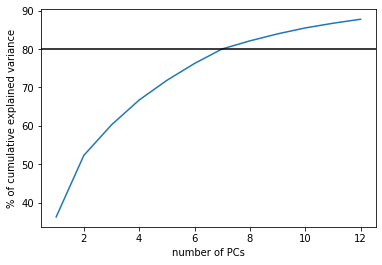

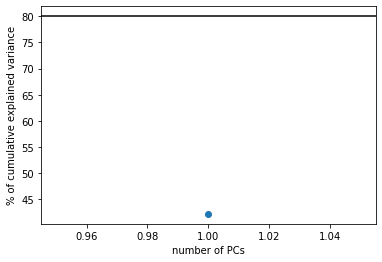

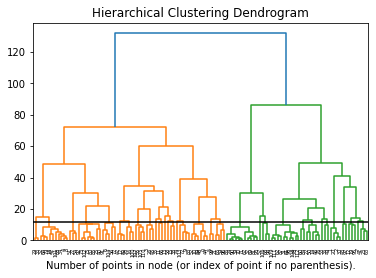

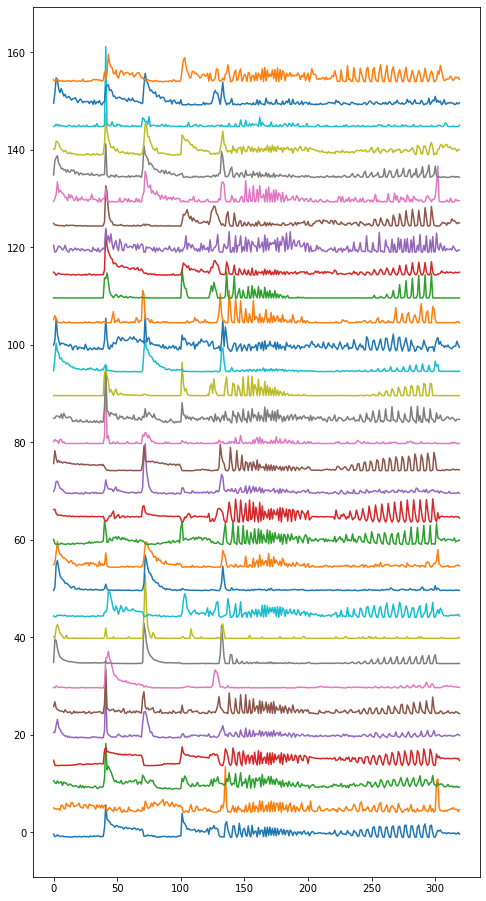

Number of clusters:  32
cluster size : 5


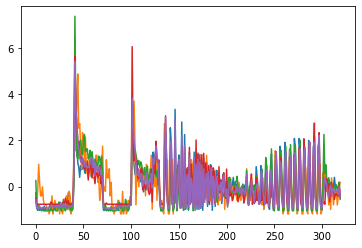

cluster size : 2


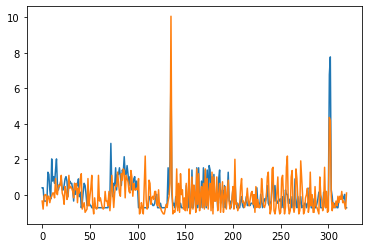

cluster size : 2


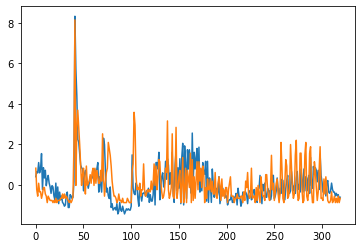

cluster size : 8


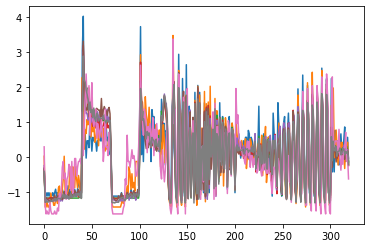

cluster size : 4


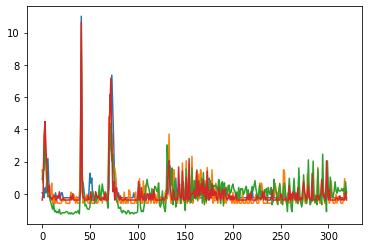

cluster size : 3


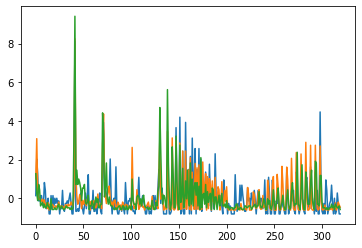

cluster size : 6


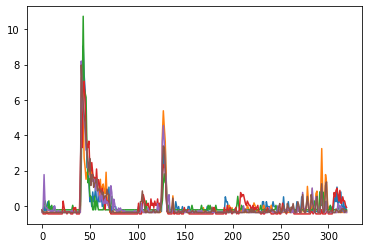

cluster size : 10


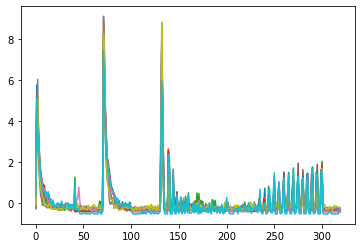

cluster size : 2


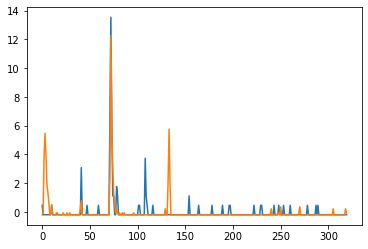

cluster size : 4


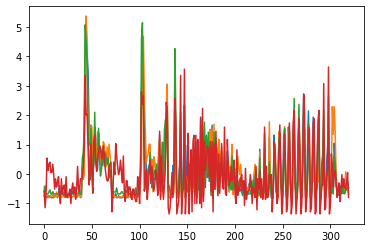

cluster size : 3


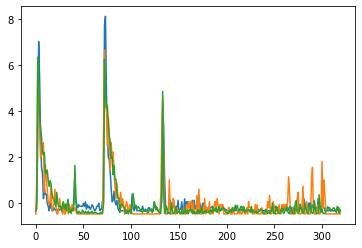

cluster size : 3


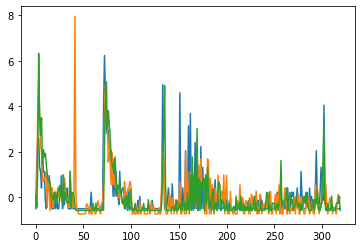

cluster size : 3


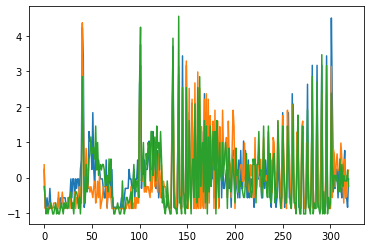

cluster size : 11


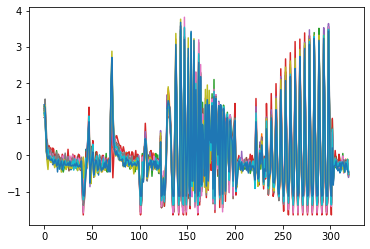

cluster size : 3


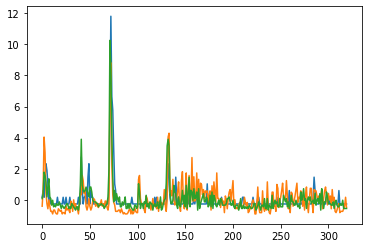

cluster size : 4


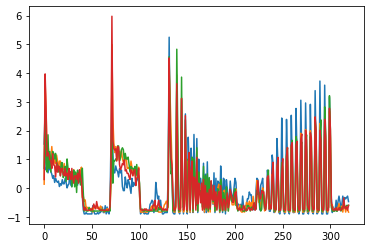

cluster size : 3


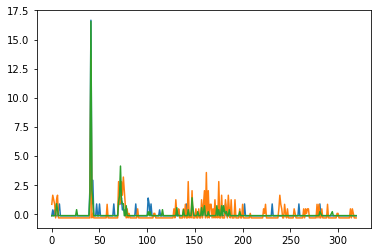

cluster size : 2


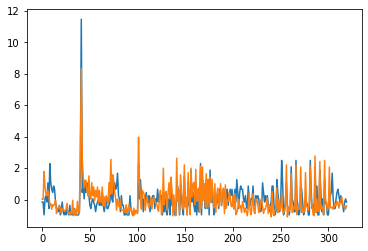

cluster size : 10


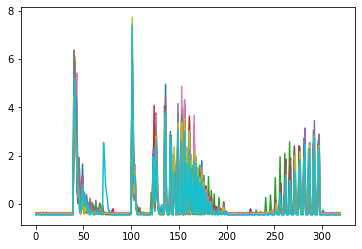

cluster size : 5


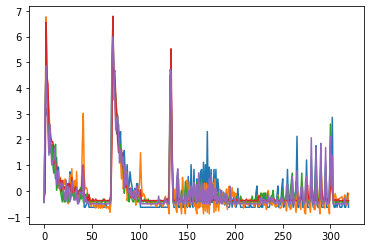

cluster size : 1


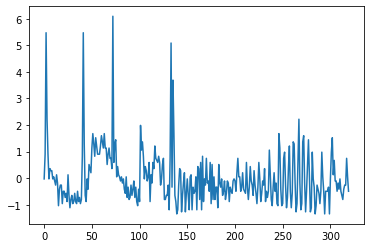

cluster size : 1


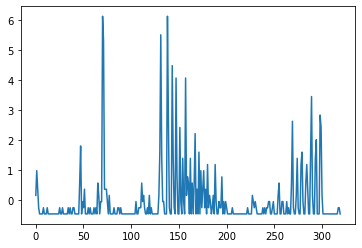

cluster size : 2


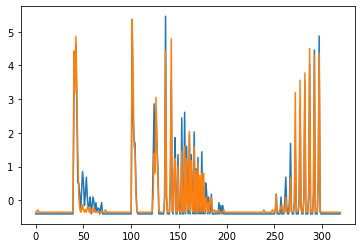

cluster size : 4


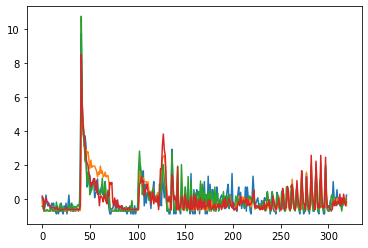

cluster size : 1


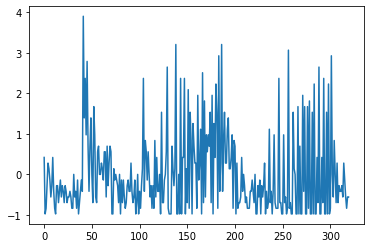

cluster size : 2


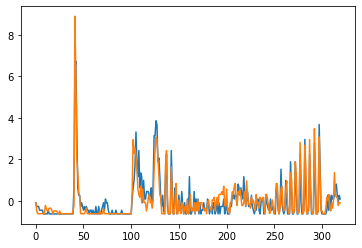

cluster size : 1


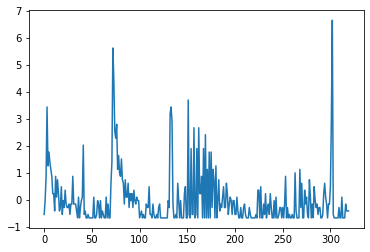

cluster size : 2


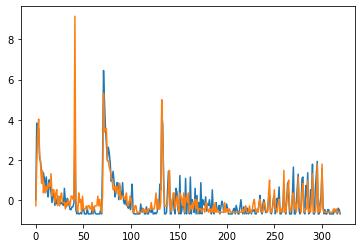

cluster size : 1


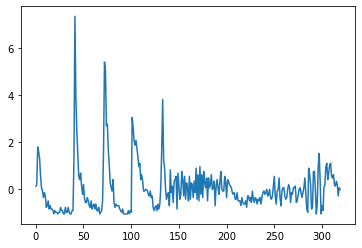

cluster size : 3


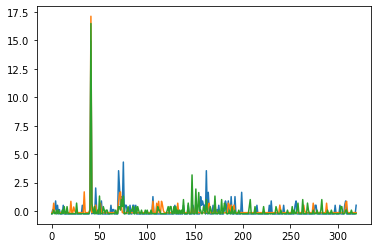

cluster size : 1


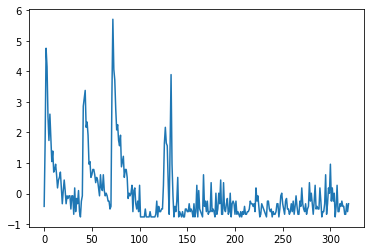

cluster size : 1


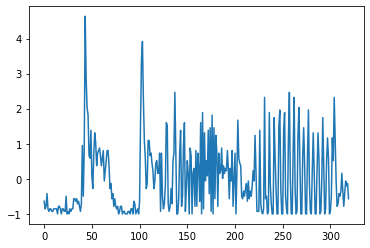

In [7]:
import scipy as sc
from sklearn.decomposition import SparsePCA
sparse=False

# change dist_thres to adapt the cut of the dendrogram and select the number of clusters
#####################################################################
dist_thres = 12 # for this exp, 14 and 15 give exactly the same results, we chose 13
#####################################################################

n_cells = len(selected_cells)

#-----------------------------------
#-----------------------------------
# Get Euler PCA
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.1 # bin size
if exp==22: 
    nt=40
    dt=0.125
time_bins = np.arange(0,nt+dt,dt)

spikes = np.zeros((n_cells, int(nt/dt), n_rep))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    spike_cell = cell_data[cell_id]["spike_trains"]
    for rep in range(n_rep):
        temp=np.histogram(spike_cell[rep], bins=time_bins)
        spikes[cell_index,:,rep] = temp[0]

#-------------------------
# Pre process the PSTH
psth = np.mean(spikes, 2)
psth_z = sc.stats.zscore(psth, 1)

# Select number of PCs to keep (here 13 explain ~80% of the variance)
#####################################################################
n_components_psth = 12  #13#16
#####################################################################
if sparse:
   pca_transformer = SparsePCA(n_components_psth, random_state=0).fit(psth_z)
else:
   pca_transformer = PCA(n_components_psth).fit(psth_z)
psth_pca = pca_transformer.transform(psth_z)
# -----------------------------------
# -----------------------------------
# Get checkerboard STA PCA
STA_time_course = np.zeros((n_cells, 40))  # 40 data points for these STAs
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    if which_STA[cell_index] == 'start':
        TempSTA_cell = cell_data[cell_id]["temporal_sta"]
    elif which_STA[cell_index] == 'end':
        TempSTA_cell = cell_data[cell_id]["temporal_sta2"]
    STA_time_course[cell_index] = TempSTA_cell
    
#---------------------------
# Pre process the STA
sta_tc = sc.stats.zscore(STA_time_course[:,:], 1)
#####################################################################
n_components_sta_tc = 1
#####################################################################
if n_components_sta_tc>0:
    pca_transformer2 = PCA(n_components_sta_tc).fit(sta_tc)
    sta_tc_pca = pca_transformer2.transform(sta_tc)
#-----------------------------------
#-----------------------------------
if not sparse:
    plt.plot(np.arange(n_components_psth)+1, np.cumsum(pca_transformer.explained_variance_ratio_)*100)
    plt.axhline(y=80, color='k')
    plt.xlabel('number of PCs')
    plt.ylabel('% of cumulative explained variance')
    plt.show()

    if n_components_sta_tc>0:
        plt.plot(np.arange(n_components_sta_tc)+1, np.cumsum(pca_transformer2.explained_variance_ratio_)*100,'o-')
        plt.axhline(y=80, color='k')
        plt.xlabel('number of PCs')
        plt.ylabel('% of cumulative explained variance')
        plt.show()
#-----------------------------------
#-----------------------------------
cluster_dataset = np.zeros((n_cells, n_components_psth+n_components_sta_tc+1))
cluster_dataset[:,:n_components_psth] = psth_pca
if n_components_sta_tc>0:
    cluster_dataset[:,n_components_psth:n_components_psth+n_components_sta_tc] = sta_tc_pca

ell_size=np.zeros(len(selected_cells))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    width,height = cell_data[cell_id]["ellipseSigmaXY"]
#     print (width, height)
    ell_size[cell_index] = np.abs(np.pi*width*height)
    
ell_size_temp = -np.ones(n_cells)
temp = ell_size[:]-ell_size[:].min()
ell_size_temp[:] = temp/temp.max()
cluster_dataset[:,-1] = ell_size_temp
#-----------------------------------
#-----------------------------------

# perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=None)
#model = model.fit(psth_pca)
model = model.fit(cluster_dataset)

# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=0)
plt.axhline(dist_thres, color='k')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# plot the cluster centroids
n_clusts = len(np.unique(model.labels_))
plt.figure(figsize=(8,16))
for iclust in range(n_clusts):
    idx_cluster = np.where(model.labels_==iclust)[0]
    plt.plot(np.mean(psth_z[idx_cluster,:], 0) + iclust * 5)
plt.show() 
    
print('Number of clusters: ',len(np.unique(model.labels_)))

# plot the psths of all cells in one cluster
for icluster in range(len(np.unique(model.labels_))):
    # icluster = 0
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(f'cluster size : {len(idx_cluster)}')
    plt.figure()
    plt.plot(psth_z[idx_cluster,:].transpose())
    plt.show()

In [8]:
# Save the cluster of each cell
for cell_index in range(len(selected_cells)):
    cell_nb = selected_cells[cell_index]
    cell_data[cell_nb]["type"] = model.labels_[cell_index]

# Save clustering results

In [9]:
# the dictionary 'call_data' with cluster type in addition
fsave = data_path + 'cells_characterization_data_with_cluster_type_clus12' + str(exp)
save_obj(cell_data,fsave)

# the model
fsave = data_path + str(exp) + '_clustermodel_clus12'
save_obj([model,psth_z],fsave)

# selected cells
fsave = data_path + str(exp) + '_selected_cells_clustering_clus12'
save_obj(selected_cells,fsave)

# Create a summary figure for each cluster type

In [10]:
def get_euler():
    if laptop:
        vec_path = 'E:/MEA data/exp19/STIMS/Euler/'
    else:
        vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
        
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return euler_vec

euler_vec= get_euler()

In [11]:
exp = 20211208

from matplotlib import gridspec

for icluster in range(len(np.unique(model.labels_)))[0:]:
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+2,6)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
        
    fig = figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    plt.suptitle("Cell group {}\n {} cells".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs = np.zeros(40)
    STAcount = 0
    waves = np.zeros(101)
    wavecount = 0
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        print (cell_nb, selected_cells[index])
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line,1])
        
#         ax.set_ylim([-4,4])
        ax.set_ylim([-2,2])
        ax.axis("off")
#         ax.set_aspect(0.075)
        if which_STA[index] == 'start':
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
        elif which_STA[index] == 'end':
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta2"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity"]
        ax.set_title('Cluster ' + str(cell_nb) + '  Polarity ' + polarity)
        ax.axhline(0,color='k',lw=0.5)
        
        if which_STA[index] == 'start':
            STAs += cell_data[cell_nb]["temporal_sta"]
        elif which_STA[index] == 'end':
            STAs += cell_data[cell_nb]["temporal_sta2"]
            
        STAcount += 1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-1,1])
        if which_STA[index] == 'start':
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
        elif which_STA[index] == 'end':
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta2"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line,0])
        
        if which_STA[index] == 'start':
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray', interpolation='gaussian')
        elif which_STA[index] == 'end':
            ax.imshow(cell_data[cell_nb]["spatial_sta2"], cmap='gray', interpolation='gaussian')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line,3:])
        
#         cell_index = selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        #-----------------
        # plot Ellipse
        if which_STA[index] == 'start':
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])
        elif which_STA[index] == 'end':
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta2"])
        
        x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
        xy = (x0, y0)

        ax= subplot(gs[line,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
        ax.add_patch(ellipse)
        
        ax= subplot(gs[0,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
        ax.add_patch(ellipse)
        
        line+=1
    #-----------------
    # avg STA
    STAs = STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40), STAs,'k',lw=2)
#     ax.set_ylim([-2,2])
#     ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(16,44)
    ax.set_ylim(44,16)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
    ax.axis("off")

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[1,3:])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[1,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/clustering 12/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' +str(icluster) 
    
    fig.savefig(fsave+'.png',format='png',dpi=250)
    close(fig)  

5
55 55
360 360
439 439
472 472


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

529 529
2
283 283
496 496
2
73 73
407 407


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

8
144 144
273 273
424 424
435 435
449 449
463 463
478 478
513 513
4
359 359
532 532
546 546
592 592
3
415 415
482 482
544 544
6
5 5
66 66
284 284
300 300
333 333
470 470
10
210 210
382 382
387 387
441 441
466 466
497 497
576 576
580 580
605 605
613 613
2
260 260
316 316
4
63 63
422 422
457 457
515 515


C:\Users\goethas\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3
136 136
276 276
389 389
3
78 78
119 119
486 486
3
158 158
329 329
356 356
11
138 138
263 263
271 271
411 411
419 419
420 420
421 421
450 450
464 464
471 471
480 480
3
22 22
153 153
287 287
4
10 10
20 20
125 125
195 195
3
100 100


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

162 162
506 506
2
99 99
270 270
10
41 41
62 62
112 112
220 220
241 241
280 280
401 401
447 447
469 469
511 511


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

5
86 86
130 130
292 292
318 318
438 438
1
83 83
1
361 361
2
168 168
238 238
4
126 126
370 370
406 406
493 493
1
247 247
2
45 45
498 498
1
335 335
2
380 380
460 460
1
368 368
3
102 102
296 296
452 452
1
56 56
1
430 430


# Compare clusters response to blur

## Load data

In [35]:
exp = 20211208

from parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(81, 4, 2, 9, 4, 25)
[  5  10  20  22  41  45  55  56  62  66  78  79  83  86  97  99 112 119
 125 130 138 144 147 153 162 168 195 210 220 238 241 260 271 273 276 280
 287 292 300 316 318 333 335 356 359 368 370 380 382 387 401 406 415 418
 419 420 421 422 424 435 438 439 441 447 449 450 457 463 464 466 469 470
 471 480 493 497 506 511 513 529 532]


## Plots

3


NameError: name 'blur_clusters' is not defined

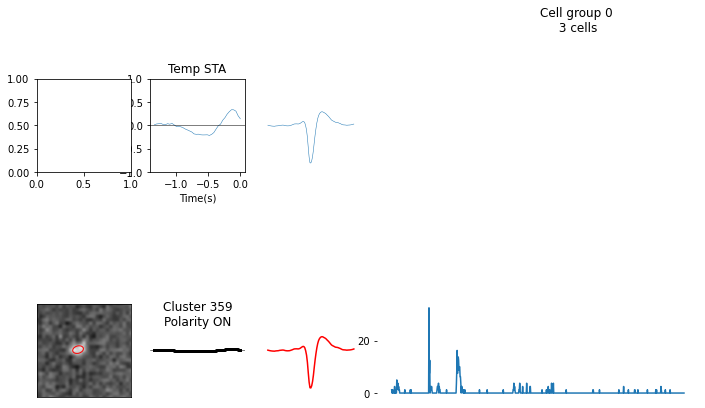

In [14]:
exp = 20211208

pup = 0

cols = ['C0','C1','C2','C3']

from matplotlib import gridspec

for icluster in range(len(np.unique(model.labels_)))[0:]:
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+2,10)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
        
    fig = figure(figsize=(20,(len(idx_cluster)+yspan)*2))
    plt.suptitle("Cell group {}\n {} cells".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs = np.zeros(40)
    STAcount = 0
    waves = np.zeros(101)
    wavecount = 0
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        
        #### Clustering results
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line,1])
        
        ax.set_ylim([-4,4])
        ax.axis("off")
        ax.set_aspect(0.075)
        ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity"]
        ax.set_title('Cluster ' + str(cell_nb) + '\nPolarity '+polarity)
        ax.axhline(0,color='k',lw=0.5)
        
        STAs += cell_data[cell_nb]["temporal_sta"]
        STAcount += 1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-1,1])
        ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line,0])
                
        ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line,3:6])
        
        cell_index=selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        #-----------------
        # plot Ellipse
        x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])
        
        x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
        xy = (x0, y0)

        ax= subplot(gs[line,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
        ax.add_patch(ellipse)
        
        ax= subplot(gs[0,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
        ax.add_patch(ellipse)
        
        ##### Cells reponse to blur
        index_bl = where(blur_clusters == selected_cells[index])[0]
        print (selected_cells[index], blur_clusters[index_bl])
        if len(index_bl) > 0:
            index_bl = index_bl[0]
            max_act = nanmax(spike_counts_mean[index_bl])

            for src in range(Nsources):
                ax = fig.add_subplot(gs[line, src + 6])
                for iImg in range(Nimgs):
                    ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                            color=cols[iImg])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.set_ylim(0,1.5*max_act)
                    ax.set_xlim(0, 9)
                    ax.set_xticks(dFs[::2])
                    if line == 2:
                        ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                        ax.set_xticklabels([])
                    if src == 0:
                        ax.set_ylabel('Spike cnt')
                    else:
                        ax.set_yticks([])
                    if line == len(idx_cluster)+1:
                        ax.set_xlabel('Defocus (D)')
                    else:
                        ax.set_xticks([])
                        
#                         ax.legend(frameon=False, fontsize = 8)
        
        line+=1
    #-----------------
    # avg STA
    STAs = STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
    ax.set_ylim([-2,2])
    ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(16,44)
    ax.set_ylim(44,16)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:6])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
    ax.axis("off")

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[1,3:6])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[1,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' + str(icluster) + '_with_blur'
    
    fig.savefig(fsave+'.png',format='png',dpi=250)
    close(fig)  
